In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression

In [99]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_gender = pd.read_csv("gender_submission.csv")

## Data Preprocessing
- Null values
- Drop features
- Feature engineering
- Binning
- Encoding

In [100]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def preprocess(df):
  # Fill na: Embarked
  df['Embarked'].fillna(np.random.choice(df['Embarked'].dropna().to_numpy()), inplace=True)

  # Adding prefix
  df['new'] = df['Name'].str.extract(r'(?<=,\s)(.*)')
  df['prefix'] = df['new'].str.extract(r'^([^\s]+)')
  df.loc[df['prefix'] == 'the'].replace('Countess')
  df = df.drop(['new'], axis = 1)

  # Fill na: Age
  mean_avg = df.groupby(['prefix']).mean()['Age']
  mean_dict = mean_avg.to_dict()

  dict_keys = list(mean_dict.keys())
  dict_values = list(mean_dict.values())
  df['Age'] = df['Age'].fillna(0)
  
  for x in range(len(dict_keys)):
      df.loc[(df['prefix'] == dict_keys[x]) & (df['Age'] == 0), 'Age'] = dict_values[x]
  df['Age'] = df['Age'].fillna(20)

  # Binning
  df['Fare'] = df['Fare'].fillna(0)
  bins = np.arange(start = -1, stop=600, step = 10)
  labels = np.arange(start = 0, stop = 60,step = 1)
  df['Fare Binned'] = pd.cut(df['Fare'], bins = bins, labels = labels)

  # Encoding
  enc = OneHotEncoder(handle_unknown='ignore')
  df = df.join(pd.DataFrame(enc.fit_transform(df[['Sex', 'Embarked']]).toarray())).drop(['Sex', 'Embarked'], axis=1)

  # Drop cabin ticket column
  df = df.drop(['Cabin', 'Ticket', 'Name', 'prefix'], axis = 1)
  return df

In [101]:
train = preprocess(df_train)
test = preprocess(df_test)

## Data Modeling - MLP

In [102]:
from sklearn.neural_network import MLPClassifier

# Running the preprocessed data from the train and test datasets with the MLP classifier
 
X_train = train[['Pclass', 'Age', 'SibSp', 'Parch','Fare','Fare Binned', 0, 1, 2, 3, 4]]
scaler.fit(X_train)
t = scaler.transform(X_train)
Y_train = train[['Survived']]

X_test = test[['Pclass', 'Age', 'SibSp', 'Parch','Fare','Fare Binned', 0, 1, 2, 3, 4]] 

clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=60, alpha= 0.05, learning_rate= 'constant',
                    activation='logistic', solver='lbfgs', verbose=1,  random_state=43) 
                                                              
 
clf.fit(t, Y_train)
y_pred_test = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [103]:
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(max_iter=100, verbose=1,  random_state=43,)

parameter_space = {
    'hidden_layer_sizes': [(100,), (100, 10, 10)],
    'activation': ['logistic'],
    'solver': ['sgd', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=4)
clf.fit(X_train, y_train)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Best parameter set
print('Best estimators found:\n', clf.best_estimator_)
print('Best parameters found:\n', clf.best_params_)

0.685 (+/-0.107) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.791 (+/-0.082) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.684 (+/-0.106) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.791 (+/-0.082) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.616 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 10, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
0.753 (+/-0.072) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 10, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.616 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 10, 10), 'learning_rate': 'adaptive', 'so

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



## Calculating the feature Importance

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



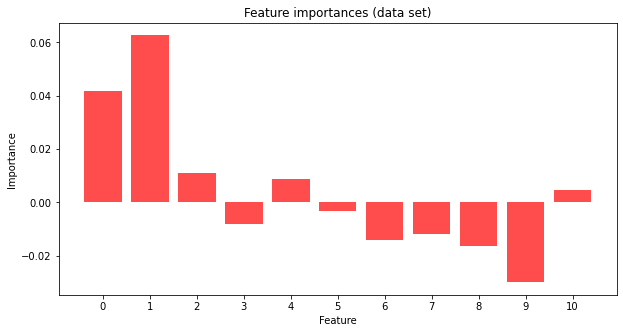

In [114]:
from sklearn.metrics import accuracy_score
y_test = submission.Survived

# Preprocess the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a classifier
 
cclf = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=60, alpha= 0.05, learning_rate= 'constant',
                    activation='logistic', solver='lbfgs', verbose=1,  random_state=43) 

 
# Fit the classifier using the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Evaluate the classifier using the test set
acc = accuracy_score(y_test, y_pred)

def get_feature_importance(j, n):
  s = accuracy_score(y_test, y_pred) # baseline score
  total = 0.0
  for i in range(n):
    perm = np.random.permutation(range(X_test.shape[0]))
    X_test_ = X_test.copy()
    X_test_[:, j] = X_test[perm, j]
    y_pred_ = clf.predict(X_test_)
    s_ij = accuracy_score(y_test, y_pred_)
    total += s_ij
  return s - total / n

# Feature importances
f = []
for j in range(X_test.shape[1]):
  f_j = get_feature_importance(j, 100)
  f.append(f_j)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(X_test.shape[1]), f, color="r", alpha=0.7)
plt.xticks(ticks=range(X_test.shape[1]))
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances (data set)")
plt.show()

In [113]:
test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Fare Binned,0,1,2,3,4
0,892,3,34.500000,0,0,7.8292,0,0.0,1.0,0.0,1.0,0.0
1,893,3,47.000000,1,0,7.0000,0,1.0,0.0,0.0,0.0,1.0
2,894,2,62.000000,0,0,9.6875,1,0.0,1.0,0.0,1.0,0.0
3,895,3,27.000000,0,0,8.6625,0,0.0,1.0,0.0,0.0,1.0
4,896,3,22.000000,1,1,12.2875,1,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,32.000000,0,0,8.0500,0,0.0,1.0,0.0,0.0,1.0
414,1306,1,39.000000,0,0,108.9000,10,1.0,0.0,1.0,0.0,0.0
415,1307,3,38.500000,0,0,7.2500,0,0.0,1.0,0.0,0.0,1.0
416,1308,3,32.000000,0,0,8.0500,0,0.0,1.0,0.0,0.0,1.0


## Submission

In [61]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_pred_test
    })

submission.to_csv('submission.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Feature insights
- Age
- Gender
- Pclass

In [90]:
# Age and survival rate
train[['Age', 'Survived']].groupby(['Age'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Age,Survived
0,0.42,1.0
10,5.00,1.0
83,63.00,1.0
72,53.00,1.0
1,0.67,1.0
...,...,...
53,36.50,0.0
34,24.50,0.0
49,34.50,0.0
42,30.50,0.0


In [92]:
# Sex and survival Rate
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


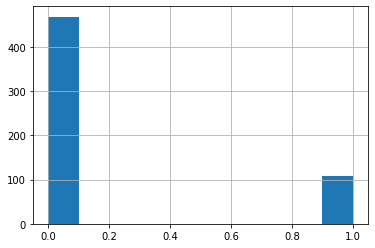

In [96]:
# Distribution of survived passengers: Male
df_train[df_train['Sex'] == 'male'].Survived.hist()

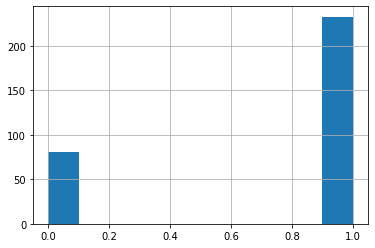

In [97]:
# Distribution of survived passengers: Female
df_train[df_train['Sex'] == 'female'].Survived.hist()

In [117]:
# Pclass
pclass_1 = df_train.loc[df_train['Pclass'] == 1]
pclass_2 = df_train.loc[df_train['Pclass'] == 2]
pclass_3 = df_train.loc[df_train['Pclass'] == 3]
pclass_1_survivalrate = len(pclass_1.loc[pclass_1['Survived'] == 1])/len(pclass_1)
pclass_2_survivalrate = len(pclass_2.loc[pclass_2['Survived'] == 1])/len(pclass_2)
pclass_3_survivalrate = len(pclass_3.loc[pclass_3['Survived'] == 1])/len(pclass_3)
print("Pclass 1 survival rate:", pclass_1_survivalrate)
print("Pclass 2 survival rate:", pclass_2_survivalrate)
print("Pclass 3 survival rate:", pclass_3_survivalrate)


Pclass 1 survival rate: 0.6296296296296297
Pclass 2 survival rate: 0.47282608695652173
Pclass 3 survival rate: 0.24236252545824846
